
# **CLPS 1291 Final Project**



In [ ]:
#@title Enter your details - {display-mode: "form"}

Name = 'Yunxi Liang'  #@param {type: "string"}
Collaborators = ''  #@param {type: "string"}



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import Adam

### FA Module Setup

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable


class LinearFANetwork(nn.Module):
    """
    Linear feed-forward networks with feedback alignment learning
    Does NOT perform non-linear activation after each layer
    """
    def __init__(self, in_features, num_layers, num_hidden_list):
        """
        :param in_features: dimension of input features (784 for MNIST)
        :param num_layers: number of layers for feed-forward net
        :param num_hidden_list: list of integers indicating hidden nodes of each layer = output features?
        """
        super(LinearFANetwork, self).__init__()
        self.in_features = in_features
        self.num_layers = num_layers
        self.num_hidden_list = num_hidden_list

        # create list of linear layers
        # first hidden layer
        self.linear = [LinearFAModule(self.in_features, self.num_hidden_list[0])] # calls FA module to build hidden layers
        # append additional hidden layers to list
        for idx in range(self.num_layers - 1):
            self.linear.append(LinearFAModule(self.num_hidden_list[idx], self.num_hidden_list[idx+1]))

        # create ModuleList to make list of layers work
        self.linear = nn.ModuleList(self.linear)

    def forward(self, inputs):
        """
        forward pass, which is same for conventional feed-forward net
        :param inputs: inputs with shape [batch_size, in_features]
        :return: logit outputs from the network
        """

        # first layer
        linear1 = self.linear[0](inputs)

        # second layer
        linear2 = self.linear[1](linear1)

        return linear2

class LinearFAModule(nn.Module):

    def __init__(self, input_features, output_features, bias=True):
        super(LinearFAModule, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # weight and bias for forward pass
        # weight has transposed form; more efficient (so i heard) (transposed at forward pass)
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            self.register_parameter('bias', None)

        # fixed random weight and bias for FA backward pass
        # does not need gradient
        self.weight_fa = Variable(torch.FloatTensor(output_features, input_features), requires_grad=False)

        # weight initialization
        torch.nn.init.kaiming_uniform(self.weight)
        torch.nn.init.kaiming_uniform(self.weight_fa)
        torch.nn.init.constant(self.bias, 1)

    def forward(self, input):
        return LinearFAFunction.apply(input, self.weight, self.weight_fa, self.bias)


class LinearFAFunction(autograd.Function): # is this like the relu activation function?

    @staticmethod
    # same as reference linear function, but with additional fa tensor for backward
    def forward(context, input, weight, weight_fa, bias=None):
        context.save_for_backward(input, weight, weight_fa, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(context, grad_output):
        input, weight, weight_fa, bias = context.saved_variables
        grad_input = grad_weight = grad_weight_fa = grad_bias = None

        if context.needs_input_grad[0]:
            # all of the logic of FA resides in this one line
            # calculate the gradient of input with fixed fa tensor, rather than the "correct" model weight
            grad_input = grad_output.mm(weight_fa.to(grad_output.device))
        if context.needs_input_grad[1]:
            # grad for weight with FA'ed grad_output from downstream layer
            # it is same with original linear function
            grad_weight = grad_output.t().mm(input)
        if bias is not None and context.needs_input_grad[3]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_weight_fa, grad_bias

### Processing data and training

In [ ]:
# SETUP and load the datasets
import os
import torch
import tensorflow_datasets as datasets
from torchvision import transforms

# check whether CUDA is available
cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available")
else:
    print("CUDA is not available")

# CIFAR-10 consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class.
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])




CUDA is available


In [ ]:
# Download and load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 99487462.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 128594154.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32608439.84it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4010637.64it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Baseline1: Build the Network: simple Con


In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        # reshape the data first to pass into conv1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # first conv layer (1->10)
        # maxpool2d (kernel=2), and then apply relu
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# second conv layer
        self.conv2_drop = nn.Dropout2d() # dropout layer
        # apply maxpool2d(kernel=2) after dropout, then apply relu
        # flatten tensor using view, prepare for fc
        self.fc1 = nn.Linear(320, 50) # fc1
        # apply relu again, and then dropout for regularization
        self.fc2 = nn.Linear(50, out_features) # fc2
        # pass this through softmax

    def forward(self, x):
        x = x.view(len(x), 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # flatten the tensor to prepare for fc
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


In [ ]:
# Train Simple CNN
import torch.optim as optim
SimpleConvNet_model = SimpleConvNet(10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SimpleConvNet_model.parameters(), lr=0.01) # used sgd as optimizer

Epoch 0, Batch 0, Loss: 2.3326
Epoch 0, Batch 100, Loss: 2.2568
Epoch 0, Batch 200, Loss: 2.1915
Epoch 0, Batch 300, Loss: 2.1498
Epoch 0, Batch 400, Loss: 1.5491
Epoch 0, Batch 500, Loss: 1.2559
Epoch 0, Batch 600, Loss: 0.9760
Epoch 0, Batch 700, Loss: 0.8559
Epoch 0, Batch 800, Loss: 0.8829
Epoch 0, Batch 900, Loss: 0.9231
Test set: Average loss: 0.0071, Accuracy: 8784/10000 (87.84%)
Epoch 1, Batch 0, Loss: 0.6006
Epoch 1, Batch 100, Loss: 0.4558
Epoch 1, Batch 200, Loss: 0.2675
Epoch 1, Batch 300, Loss: 0.3420
Epoch 1, Batch 400, Loss: 0.1586
Epoch 1, Batch 500, Loss: 0.1680
Epoch 1, Batch 600, Loss: 0.1103
Epoch 1, Batch 700, Loss: 0.2984
Epoch 1, Batch 800, Loss: 0.1363
Epoch 1, Batch 900, Loss: 0.1482
Test set: Average loss: 0.0030, Accuracy: 9445/10000 (94.45%)
Epoch 2, Batch 0, Loss: 0.3172
Epoch 2, Batch 100, Loss: 0.2379
Epoch 2, Batch 200, Loss: 0.1812
Epoch 2, Batch 300, Loss: 0.1212
Epoch 2, Batch 400, Loss: 0.1567
Epoch 2, Batch 500, Loss: 0.2103
Epoch 2, Batch 600, Loss

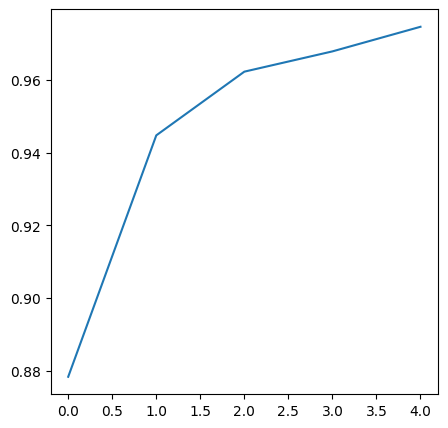

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
plt.ion()

epochs = 5
val_accuracies = []
for epoch in range(epochs):
      for batch_id, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = SimpleConvNet_model(data)
        loss = criterion(output, target) # criterion ouptut a loss item
        loss.backward()
        optimizer.step()

        if batch_id % 100 ==0:
          print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss.item()))


      SimpleConvNet_model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          val_acc = []
          for data, target in test_loader:
              output = SimpleConvNet_model(data)
              test_loss += criterion(output, target).item()
              pred = output.argmax(dim=1, keepdim=True)
              correct += pred.eq(target.view_as(pred)).sum().item()
              val_acc.append((pred == target.view_as(pred)).float().mean().item())
          val_accuracies.append(np.mean(val_acc))

      test_loss /= len(test_loader.dataset) # returns average test loss
      accuracy = correct / len(test_loader.dataset)

      print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
          test_loss, correct, len(test_loader.dataset), 100. * accuracy))
plt.plot(val_accuracies)


### Baseline3: Weight Extraction and build FA

In [ ]:
# Weight extraction
trained_model = SimpleConvNet_model
state_dict = trained_model.state_dict()
conv1_weights = state_dict['conv1.weight']
conv2_weights = state_dict['conv2.weight']

In [ ]:
from torch.nn import Parameter
class SimpleConvNet_withFA(nn.Module):
    def __init__(self, out_features, conv1_weights, conv2_weights):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1.weight = Parameter(conv1_weights)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2.weight = Parameter(conv2_weights)
        self.conv2_drop = nn.Dropout2d()
        # freeze the above 3 layers
        self.conv1.requires_grad = False
        self.conv2.requires_grad = False
        self.conv2_drop.requires_grad = False

        self.fa1 = LinearFAModule(320, 50) # just specify size?
        self.fa2 = LinearFAModule(50, out_features)

    def forward(self, x):
        #print("Input size:", x.size())
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("After conv1 size:", x.size())
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print("After conv2 size:", x.size())
        # Flatten the tensor to prepare for fc
        x = x.view(-1, 320)
        #print("After view size:", x.size())
        x = F.relu(self.fa1(x))
        #print("After fa1 size:", x.size())
        x = F.dropout(x, training=self.training)
        x = self.fa2(x)
        #print("Final output size:", x.size())
        return F.log_softmax(x, dim=-1)

        # # x = x.view(-1, 1, 28, 28)
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # # flatten the tensor to prepare for fc
        # x = x.view(-1, self.conv2.out_channels)
        # x = F.relu(self.fa1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fa2(x)
        # return F.log_softmax(x, dim=-1)

conv_withfa = SimpleConvNet_withFA(10, conv1_weights, conv2_weights)
optimizer_fa = torch.optim.SGD(conv_withfa.parameters(),
                            lr=0.0001)

<ipython-input-3-315a784c8d12>:69: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
<ipython-input-3-315a784c8d12>:70: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)
<ipython-input-3-315a784c8d12>:71: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(self.bias, 1)


<ipython-input-3-315a784c8d12>:90: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  input, weight, weight_fa, bias = context.saved_variables


Epoch 0, Batch 0, Loss: 19.8490
Epoch 0, Batch 100, Loss: 16.7700
Epoch 0, Batch 200, Loss: 16.5131
Epoch 0, Batch 300, Loss: 18.1051
Epoch 0, Batch 400, Loss: 15.8396
Epoch 0, Batch 500, Loss: 16.7095
Epoch 0, Batch 600, Loss: 13.6263
Epoch 0, Batch 700, Loss: 14.4901
Epoch 0, Batch 800, Loss: 15.5837
Epoch 0, Batch 900, Loss: 13.7373
Test set: Average loss: 0.0764, Accuracy: 1517/10000 (15.17%)
Epoch 1, Batch 0, Loss: 5.1904
Epoch 1, Batch 100, Loss: 3.8309
Epoch 1, Batch 200, Loss: 3.3519
Epoch 1, Batch 300, Loss: 3.4892
Epoch 1, Batch 400, Loss: 3.7755
Epoch 1, Batch 500, Loss: 3.4248
Epoch 1, Batch 600, Loss: 3.5199
Epoch 1, Batch 700, Loss: 3.1255
Epoch 1, Batch 800, Loss: 3.1491
Epoch 1, Batch 900, Loss: 3.4285
Test set: Average loss: 0.0452, Accuracy: 2914/10000 (29.14%)
Epoch 2, Batch 0, Loss: 3.0228
Epoch 2, Batch 100, Loss: 2.9092
Epoch 2, Batch 200, Loss: 2.5931
Epoch 2, Batch 300, Loss: 2.3003
Epoch 2, Batch 400, Loss: 2.0607
Epoch 2, Batch 500, Loss: 2.7548
Epoch 2, Batch

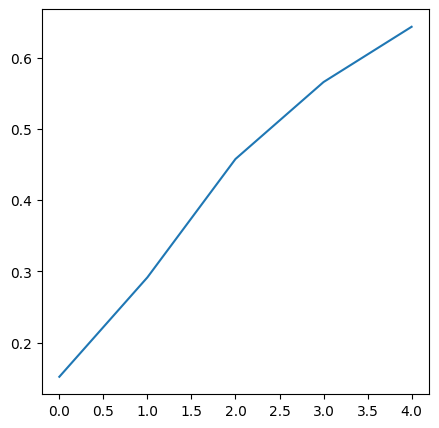

In [ ]:
epochs = 5
val_accuracies = []
for epoch in range(epochs):
    for batch_id, (inputs, targets) in enumerate(train_loader):
        optimizer_fa.zero_grad()
        outputs_fa = conv_withfa(inputs)
        #print(inputs.shape, targets.shape, outputs_fa.shape)
        # calculate loss
        loss_fa = criterion(outputs_fa, targets)
        loss_fa.backward()
        optimizer_fa.step()

        if batch_id % 100 ==0:
          print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss_fa.item()))

    conv_withfa.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        val_acc=[]
        for data, target in test_loader:
            output = conv_withfa(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            val_acc.append((pred == target.view_as(pred)).float().mean().item())
        val_accuracies.append(np.mean(val_acc))

    test_loss /= len(test_loader.dataset) # returns average test loss
    accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), 100. * accuracy))

plt.plot(val_accuracies)

### Models ran on CIFAR-10

In [ ]:
# Process CIFAR10
import torchvision

def load_cifar10(batch_size):
    DOWNLOAD_CIFAR10 = False
    if not(os.path.exists('./cifar10/')) or not os.listdir('./cifar10/'):
        DOWNLOAD_CIFAR10 = True

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #for each RGB channel.
    ])

    train_data = torchvision.datasets.CIFAR10(
        root='./cifar10/', train=True,
        download=DOWNLOAD_CIFAR10, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    test_data = torchvision.datasets.CIFAR10(
        root='./cifar10/', train=False,
        download=DOWNLOAD_CIFAR10, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader_cifar,test_loader_cifar = load_cifar10(64)


100%|██████████| 170498071/170498071 [00:10<00:00, 16166875.23it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


In [ ]:
class SimpleConvNet_cifar(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        # reshape the data first to pass into conv1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)  # Change input channels to 3
        # maxpool2d (kernel=2), and then apply relu
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # second conv layer
        self.conv2_drop = nn.Dropout2d()  # dropout layer
        # apply maxpool2d(kernel=2) after dropout, then apply relu
        # flatten tensor using view, prepare for fc

        self.fc1 = nn.Linear(32*8*8, 50)  # Adjust input size for fc1
        # apply relu again, and then dropout for regularization
        self.fc2 = nn.Linear(50, out_features)  # fc2
        # pass this through softmax

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # flatten the tensor to prepare for fc
        x = x.view(-1, 32*8*8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

# Train Simple CNN
import torch.optim as optim
SimpleConvNet_cifar = SimpleConvNet_cifar(10)

criterion = nn.CrossEntropyLoss()
optimizer_cifar = optim.SGD(SimpleConvNet_cifar.parameters(), lr=0.01) # used sgd as optimizer

Epoch 0, Batch 0, Loss: 2.3118
Epoch 0, Batch 100, Loss: 2.3033
Epoch 0, Batch 200, Loss: 2.2667
Epoch 0, Batch 300, Loss: 2.2165
Epoch 0, Batch 400, Loss: 2.1383
Epoch 0, Batch 500, Loss: 2.1616
Epoch 0, Batch 600, Loss: 1.9997
Epoch 0, Batch 700, Loss: 2.0997
Test set: Average loss: 0.0313, Accuracy: 2955/10000 (29.55%)
Epoch 1, Batch 0, Loss: 2.0810
Epoch 1, Batch 100, Loss: 2.0144
Epoch 1, Batch 200, Loss: 1.9839
Epoch 1, Batch 300, Loss: 1.8736
Epoch 1, Batch 400, Loss: 1.8218
Epoch 1, Batch 500, Loss: 1.7693
Epoch 1, Batch 600, Loss: 1.9842
Epoch 1, Batch 700, Loss: 1.6140
Test set: Average loss: 0.0257, Accuracy: 4127/10000 (41.27%)
Epoch 2, Batch 0, Loss: 1.7711
Epoch 2, Batch 100, Loss: 1.6358
Epoch 2, Batch 200, Loss: 1.6080
Epoch 2, Batch 300, Loss: 1.5507
Epoch 2, Batch 400, Loss: 1.4822
Epoch 2, Batch 500, Loss: 1.5455
Epoch 2, Batch 600, Loss: 1.5954
Epoch 2, Batch 700, Loss: 1.6767
Test set: Average loss: 0.0235, Accuracy: 4527/10000 (45.27%)
Epoch 3, Batch 0, Loss: 1.52

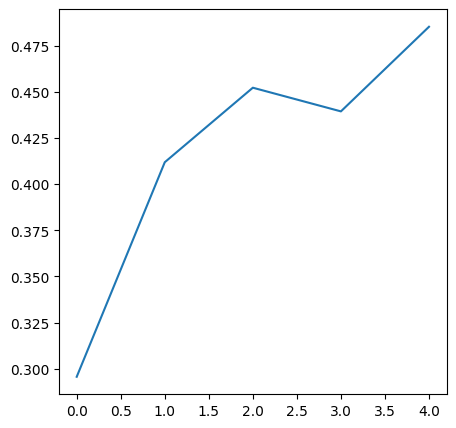

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
plt.ion()

epochs = 5
val_accuracies = []
for epoch in range(epochs):
      for batch_id, (data, target) in enumerate(train_loader_cifar):
        optimizer_cifar.zero_grad()
        output = SimpleConvNet_cifar(data)
        loss = criterion(output, target) # criterion ouptut a loss item
        loss.backward()
        optimizer_cifar.step()

        if batch_id % 100 ==0:
          print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss.item()))


      SimpleConvNet_cifar.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          val_acc = []
          for data, target in test_loader_cifar:
              output = SimpleConvNet_cifar(data)
              test_loss += criterion(output, target).item()
              pred = output.argmax(dim=1, keepdim=True)
              correct += pred.eq(target.view_as(pred)).sum().item()
              val_acc.append((pred == target.view_as(pred)).float().mean().item())
          val_accuracies.append(np.mean(val_acc))

      test_loss /= len(test_loader_cifar.dataset) # returns average test loss
      accuracy = correct / len(test_loader_cifar.dataset)

      print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
          test_loss, correct, len(test_loader_cifar.dataset), 100. * accuracy))
plt.plot(val_accuracies)


In [ ]:
# Weight extraction
trained_cifar = SimpleConvNet_cifar
state_dict = trained_cifar.state_dict()
conv1_weights = state_dict['conv1.weight']
conv2_weights = state_dict['conv2.weight']

from torch.nn import Parameter
class SimpleConvNet_withFA_cifar(nn.Module):
    def __init__(self, out_features, conv1_weights, conv2_weights):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = Parameter(conv1_weights)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv2.weight = Parameter(conv2_weights)
        self.conv2_drop = nn.Dropout2d()
        # freeze the above 3 layers
        self.conv1.requires_grad = False
        self.conv2.requires_grad = False
        self.conv2_drop.requires_grad = False

        self.fa1 = LinearFAModule(32*8*8, 50) # just specify size?
        self.fa2 = LinearFAModule(50, out_features)

    def forward(self, x):
        #print("Input size:", x.size())
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("After conv1 size:", x.size())
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print("After conv2 size:", x.size())
        # Flatten the tensor to prepare for fc
        x = x.view(-1, 32*8*8)
        #print("After view size:", x.size())
        x = F.relu(self.fa1(x))
        #print("After fa1 size:", x.size())
        x = F.dropout(x, training=self.training)
        x = self.fa2(x)
        #print("Final output size:", x.size())
        return F.log_softmax(x, dim=-1)

conv_withfa_cifar = SimpleConvNet_withFA_cifar(10, conv1_weights, conv2_weights)
optimizer_fa_cifar = torch.optim.SGD(conv_withfa_cifar.parameters(),
                            lr=0.0001)

<ipython-input-2-315a784c8d12>:69: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
<ipython-input-2-315a784c8d12>:70: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)
<ipython-input-2-315a784c8d12>:71: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(self.bias, 1)


<ipython-input-2-315a784c8d12>:90: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  input, weight, weight_fa, bias = context.saved_variables


Epoch 0, Batch 0, Loss: 2.9806
Epoch 0, Batch 100, Loss: 2.5856
Epoch 0, Batch 200, Loss: 2.4199
Epoch 0, Batch 300, Loss: 2.4749
Epoch 0, Batch 400, Loss: 2.9249
Epoch 0, Batch 500, Loss: 2.7056
Epoch 0, Batch 600, Loss: 2.5705
Epoch 0, Batch 700, Loss: 2.3257
Test set: Average loss: 0.0401, Accuracy: 1815/10000 (18.15%)
Epoch 1, Batch 0, Loss: 2.7923
Epoch 1, Batch 100, Loss: 2.2690
Epoch 1, Batch 200, Loss: 2.1764
Epoch 1, Batch 300, Loss: 2.6324
Epoch 1, Batch 400, Loss: 2.7278
Epoch 1, Batch 500, Loss: 2.7041
Epoch 1, Batch 600, Loss: 2.2994
Epoch 1, Batch 700, Loss: 2.4572
Test set: Average loss: 0.0398, Accuracy: 2036/10000 (20.36%)
Epoch 2, Batch 0, Loss: 2.3699
Epoch 2, Batch 100, Loss: 2.3485
Epoch 2, Batch 200, Loss: 2.2925
Epoch 2, Batch 300, Loss: 2.7011
Epoch 2, Batch 400, Loss: 2.1809
Epoch 2, Batch 500, Loss: 2.3825
Epoch 2, Batch 600, Loss: 2.6179
Epoch 2, Batch 700, Loss: 2.5523
Test set: Average loss: 0.0388, Accuracy: 2270/10000 (22.70%)
Epoch 3, Batch 0, Loss: 2.17

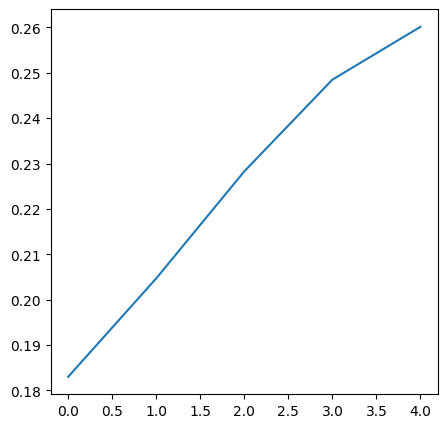

In [ ]:
epochs = 5
val_accuracies = []
for epoch in range(epochs):
    for batch_id, (inputs, targets) in enumerate(train_loader_cifar):
        optimizer_fa_cifar.zero_grad()
        outputs_fa = conv_withfa_cifar(inputs)
        #print(inputs.shape, targets.shape, outputs_fa.shape)
        # calculate loss
        loss_fa = criterion(outputs_fa, targets)
        loss_fa.backward()
        optimizer_fa_cifar.step()

        if batch_id % 100 ==0:
          print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss_fa.item()))

    conv_withfa_cifar.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        val_acc=[]
        for data, target in test_loader_cifar:
            output = conv_withfa_cifar(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            val_acc.append((pred == target.view_as(pred)).float().mean().item())
        val_accuracies.append(np.mean(val_acc))

    test_loss /= len(test_loader_cifar.dataset) # returns average test loss
    accuracy = correct / len(test_loader_cifar.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader_cifar.dataset), 100. * accuracy))

plt.plot(val_accuracies)